In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [832]:
N = 100 # number of data points per class
K = 3   # number of classes
D = 2   # Dimensionality

X = np.zeros((N*K, D))
Y = np.zeros(N*K, dtype=int)

for i in range(K):
    r = np.linspace(0, 1, N)
    t = np.linspace(4*i, 4*(i+1), N) + np.random.randn(N)*0.4
    coords = np.c_[r*np.cos(t), r*np.sin(t)]
    X[i*N:(i+1)*N, :] = coords
    Y[i*N:(i+1)*N] = int(i)

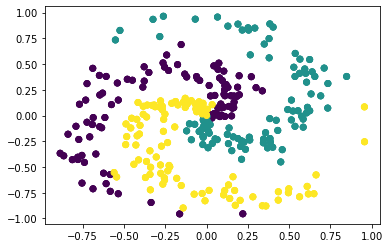

In [833]:
for i in range(K): 
    plt.scatter(X[:, 0], X[:, 1], c=Y)

In [839]:
# build a simple linear classifier 

# initialize parameters
n_hidden = 100
np.random.seed(1234)
W1 = np.random.randn(D, n_hidden) * 0.01
b1 = np.random.randn(n_hidden) * 0

W2 = np.random.randn(n_hidden, K) / (n_hidden)**(1/2)
b2 = np.random.randn(K) * 0

# W2 = np.random.randn(D, K) * 0.01
# b2 = np.random.randn(K) * 0

# hyperparameters
reg = 2e-4   # L2 reg
num_examples = K*N
alpha = 2e-3
beta1 = 0.9
beta2 = 0.99
eps = 1e-8
ema_mean_W1 = np.zeros(np.shape(W1))
ema_mean_b1 = np.zeros(np.shape(b1))
ema_mean_W2 = np.zeros(np.shape(W2))
ema_mean_b2 = np.zeros(np.shape(b2))
ema_var_W1 = np.zeros(np.shape(W1))
ema_var_b1 = np.zeros(np.shape(b1))
ema_var_W2 = np.zeros(np.shape(W2))
ema_var_b2 = np.zeros(np.shape(b2))
ema_unb_mean_W1 = np.zeros(np.shape(W1))
ema_unb_mean_b1 = np.zeros(np.shape(b1))
ema_unb_mean_W2 = np.zeros(np.shape(W2))
ema_unb_mean_b2 = np.zeros(np.shape(b2))
ema_unb_var_W1 = np.zeros(np.shape(W1))
ema_unb_var_b1 = np.zeros(np.shape(b1))
ema_unb_var_W2 = np.zeros(np.shape(W2))
ema_unb_var_b2 = np.zeros(np.shape(b2))

loss_array = []
W1_array = []
W2_array = []
b1_array = []
b2_array = []

iterations = 10000

for i in range(iterations):
    # forward pass
    h_pre = np.dot(X, W1) + b1
    h = np.maximum(0, h_pre)   # implements reLU
    logits = np.dot(h, W2) + b2
    exp_logits = np.exp(logits)
    probs = exp_logits/np.sum(exp_logits, axis=1, keepdims=True)
    y_pred = np.argmax(probs, axis=1)
    losses = -np.log(probs[range(num_examples), Y])
    loss_data = 1/(num_examples) * np.sum(losses)
    
    loss_reg = 1/2 * reg * (np.sum(W2*W2) + np.sum(W1*W1))
    
    loss = loss_data + loss_reg

    # backward pass - analytical gradient analysis 
    dprobs = np.zeros((num_examples, K))
    dprobs[range(num_examples), Y] = -1/(num_examples) * 1/probs[range(num_examples), Y]

    dlogits = -probs[range(num_examples), Y].reshape(num_examples,1) * probs
    dlogits[range(num_examples),Y] += probs[range(num_examples), Y]
    dlogits *= dprobs.sum(1, keepdims=True)
    
    dW2 = np.dot(h.T, dlogits) + reg * W2
#     dW2 = np.dot(X.T, dlogits) + reg * W2
    db2 = dlogits.sum(0, keepdims=False)
    
    dh = np.dot(dlogits, W2.T)
    dh_pre = dh * (h > 0)
    
    dW1 = np.dot(X.T, dh_pre) + reg * W1
    db1 = dh_pre.sum(0, keepdims=False)

    # update parameters 
    # 1) Update ADAM parameters 
    ema_mean_W1 = (beta1) * ema_mean_W1 + (1 - beta1) * dW1
    ema_mean_W2 = (beta1) * ema_mean_W2 + (1 - beta1) * dW2
    ema_mean_b1 = (beta1) * ema_mean_b1 + (1 - beta1) * db1
    ema_mean_b2 = (beta1) * ema_mean_b2 + (1 - beta1) * db2
    ema_var_W1 = (beta2) * ema_var_W1 + (1 - beta2) * dW1**2
    ema_var_W2 = (beta2) * ema_var_W2 + (1 - beta2) * dW2**2
    ema_var_b1 = (beta2) * ema_var_b1 + (1 - beta2) * db1**2
    ema_var_b2 = (beta2) * ema_var_b2 + (1 - beta2) * db2**2
    
    ema_unb_mean_W1 = ema_mean_W1/(1 - beta1**(i+1))
    ema_unb_mean_W2 = ema_mean_W2/(1 - beta1**(i+1))
    ema_unb_mean_b1 = ema_mean_b1/(1 - beta1**(i+1))
    ema_unb_mean_b2 = ema_mean_b2/(1 - beta1**(i+1))
    ema_unb_var_W1 = ema_var_W1/(1 - beta2**(i+1))
    ema_unb_var_W2 = ema_var_W2/(1 - beta2**(i+1))
    ema_unb_var_b1 = ema_var_b1/(1 - beta2**(i+1))
    ema_unb_var_b2 = ema_var_b2/(1 - beta2**(i+1))
    
    W2 -= alpha * ema_unb_mean_W2/(ema_unb_var_W2 ** (0.5) + eps)
    b2 -= alpha * ema_unb_mean_b2/(ema_unb_var_b2 ** (0.5) + eps)
    W1 -= alpha * ema_unb_mean_W1/(ema_unb_var_W1 ** (0.5) + eps)
    b1 -= alpha * ema_unb_mean_b1/(ema_unb_var_b1 ** (0.5) + eps)
    
#     if i < 4000:
#         lr = 1.5
#     elif i < 6000:
#         lr = 0.5
#     elif i < 10000: 
#         lr = 0.1
    
#     W2 -= lr * dW2
#     W1 -= lr * dW1
#     b2 -= lr * db2
#     b1 -= lr * db1
    
    # report loss and track weights/biases
    if i % 1000 == 0: 
        print(f"{i}/{iterations}: loss = {loss}, (data_loss = {loss_data}, data_reg = {loss_reg})")
              
    W1_array.append(W1.flatten().tolist())
    b1_array.append(b1.flatten().tolist())
    W2_array.append(W2.flatten().tolist())
    b2_array.append(b2.flatten().tolist())
              
    loss_array.append(np.log(loss))

0/10000: loss = 1.098310184394002, (data_loss = 1.0980443360378236, data_reg = 0.00026584835617843376)
1000/10000: loss = 0.22038627380971432, (data_loss = 0.1665687469153004, data_reg = 0.053817526894413895)
2000/10000: loss = 0.15853765907775563, (data_loss = 0.07251291274843631, data_reg = 0.08602474632931933)
3000/10000: loss = 0.15274108239193546, (data_loss = 0.06680933634420175, data_reg = 0.0859317460477337)
4000/10000: loss = 0.15135420318934617, (data_loss = 0.06593189090920022, data_reg = 0.08542231228014596)
5000/10000: loss = 0.15097022382698982, (data_loss = 0.06559477989487716, data_reg = 0.08537544393211266)
6000/10000: loss = 0.1508049865767493, (data_loss = 0.06548475033202106, data_reg = 0.08532023624472823)
7000/10000: loss = 0.15072787898799972, (data_loss = 0.06544084591234012, data_reg = 0.0852870330756596)
8000/10000: loss = 0.15066703246916832, (data_loss = 0.06540902815840068, data_reg = 0.08525800431076765)
9000/10000: loss = 0.15063013405221193, (data_loss =

In [790]:
print(f"ema_mean_W1 | mean = {ema_mean_W1.mean()} | std = {ema_mean_W1.std()}")
print(f"ema_mean_W2 | mean = {ema_mean_W2.mean()} | std = {ema_mean_W2.std()}")
print(f"ema_mean_b1 | mean = {ema_mean_b1.mean()} | std = {ema_mean_b1.std()}")
print(f"ema_mean_b2 | mean = {ema_mean_b2.mean()} | std = {ema_mean_b2.std()}")
print(f"ema_var_W1 | mean = {ema_var_W1.mean()} | std = {ema_var_W1.std()}")
print(f"ema_var_W2 | mean = {ema_var_W2.mean()} | std = {ema_var_W2.std()}")
print(f"ema_var_b1 | mean = {ema_var_b1.mean()} | std = {ema_var_b1.std()}")
print(f"ema_var_b2 | mean = {ema_var_b2.mean()} | std = {ema_var_b2.std()}")


ema_mean_W1 | mean = -1.2553210993657795e-07 | std = 2.1678312767459997e-05
ema_mean_W2 | mean = 1.525259470495161e-07 | std = 2.8620617936403124e-05
ema_mean_b1 | mean = 7.705756451128087e-07 | std = 4.3965952775831786e-05
ema_mean_b2 | mean = 1.7982509470208796e-18 | std = 7.176022007707442e-06
ema_var_W1 | mean = 8.996154557125706e-08 | std = 8.819774397495393e-07
ema_var_W2 | mean = 2.4144879151558127e-07 | std = 3.4680369091611976e-07
ema_var_b1 | mean = 3.1652337976968985e-07 | std = 1.4677331972354133e-06
ema_var_b2 | mean = 1.529008964748203e-07 | std = 5.880936686153903e-08


In [835]:
# evaluate training set accuracy 
def get_input_for_class(myclass): 
    (myX, myY) = {1: (X[:100], Y[:100]),
            2: (X[100:200], Y[100:200]),
            3: (X[200:300], Y[200:300])
            }[myclass]

    return myX, myY

myX, myY = get_input_for_class(2)

h_pre = np.dot(myX, W1) + b1
h = h_pre * (h_pre > 0)
logits = np.dot(h, W2) + b2
y_pred = np.argmax(logits, axis=1)
print(f"Training Accuracy = {np.sum((y_pred == myY))/(len(myX))* 100}%")

Training Accuracy = 100.0%


[-1.30707788  0.86519724  0.08534369]


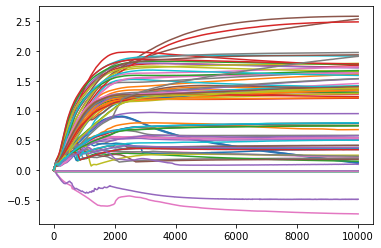

In [836]:
# plt.plot([sum(w)/len(w) for w in W1_array], label='W1')
# plt.plot([sum(w)/len(w) for w in W2_array], label='W2')
# plt.plot([sum(w)/len(w) for w in b1_array], label='b1')
plt.plot([w for w in b1_array])
print(b2)

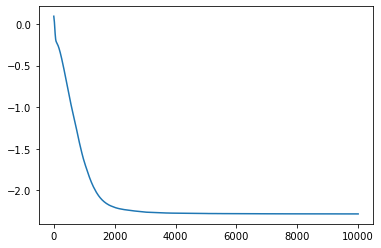

In [837]:
plt.plot(loss_array)

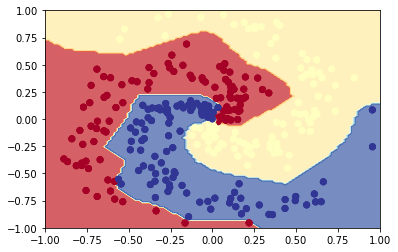

In [840]:
# plot decision boundary 

xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = xx.flatten()
y = yy.flatten() 
coords = np.c_[x, y]

h_pre = np.dot(coords, W1) + b1
h = np.maximum(0, h_pre)
logits = np.dot(h, W2) + b2
y_pred = np.argmax(logits, axis=1)
zz = y_pred.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap=plt.cm.RdYlBu, alpha=0.7)
for i in range(K): 
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

[-0.29741056 -0.43496298  0.40552378]


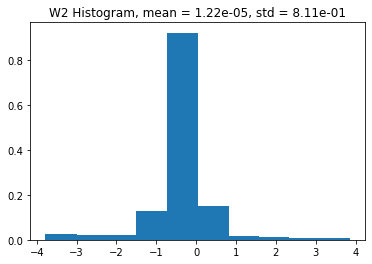

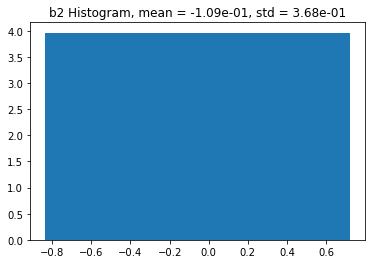

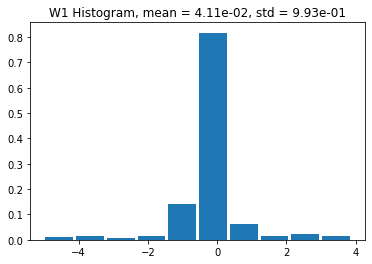

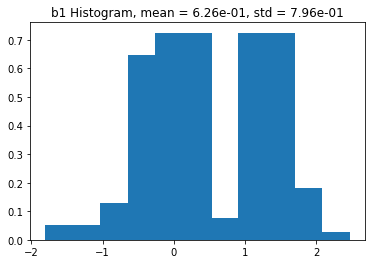

In [821]:
plt.figure()
pdf, bin_edges = np.histogram(W2, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title(f"W2 Histogram, mean = {W2.mean():.2e}, std = {W2.std():.2e}")

plt.figure()
pdf, bin_edges = np.histogram(b2, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title(f"b2 Histogram, mean = {b2.mean():.2e}, std = {b2.std():.2e}")

plt.figure()
pdf, bin_edges = np.histogram(W1, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title(f"W1 Histogram, mean = {W1.mean():.2e}, std = {W1.std():.2e}")

plt.figure()
pdf, bin_edges = np.histogram(b1, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title(f"b1 Histogram, mean = {b1.mean():.2e}, std = {b1.std():.2e}")

print(b2)

[[0.         0.         0.         ... 0.         0.         0.96999475]
 [0.         0.         0.         ... 0.         0.         0.9717603 ]
 [0.         0.         0.         ... 0.         0.         0.97352585]
 ...
 [2.12695354 3.50191096 0.91412122 ... 2.04967883 0.91812002 0.        ]
 [2.14899904 3.49896146 0.94230291 ... 2.07092998 0.94646024 0.        ]
 [2.17104455 3.49601197 0.97048461 ... 2.09218112 0.97480046 0.        ]]


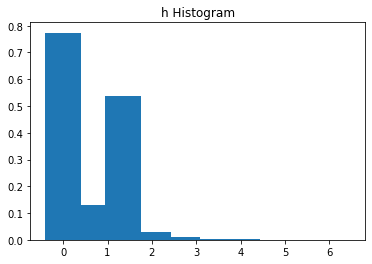

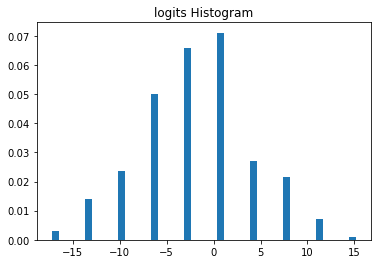

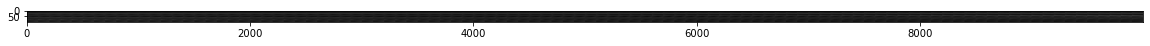

In [825]:
# plot activations
plt.figure()
pdf, bin_edges = np.histogram(h, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title("h Histogram")

# print(b2)

plt.figure()
pdf, bin_edges = np.histogram(logits, density=True)
plt.bar(bin_edges[:-1], pdf)
plt.title("logits Histogram")

# print(b1)

plt.figure(figsize=[20, 10])
plt.imshow(h.T, cmap='gray')

print(h)